# 任务一：SimCLR 自监督学习 (MindSpore 版)



## 环境与依赖
只用 MindSpore + 科学计算基础库，绘图用 matplotlib，可选 t-SNE 需要 scikit-learn。


In [23]:
import os, random, pickle, math
import numpy as np
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import nn, ops, Tensor
import mindspore.dataset as ds
from mindspore import context

from PIL import Image, ImageEnhance, ImageFilter

# Force Ascend + GRAPH mode on Huawei Cloud; change device_id if needed
ms.set_context(mode=context.PYNATIVE_MODE, device_target="Ascend", device_id=0)
ms.set_seed(42)
np.random.seed(42)
random.seed(42)
print("Device:", ms.get_context("device_target"))


Device: Ascend


## 读入 CIFAR-10 并子采样约 100 张
为了让三项任务都能很快跑完，这里从全量训练集中随机抽 100 张，测试集抽 20 张用于可视化。


In [24]:
data_root = "./dataset/cifar-10-batches-py"

def load_batch(file_path):
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
    data = data_dict['data'] if 'data' in data_dict else data_dict[b'data']
    labels_raw = data_dict.get('labels') if 'labels' in data_dict else data_dict.get(b'labels')
    images = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(labels_raw, dtype=np.int32)
    return images, labels

def load_cifar10(root):
    train_imgs, train_labels = [], []
    for i in range(1, 6):
        imgs, labs = load_batch(os.path.join(root, f"data_batch_{i}"))
        train_imgs.append(imgs)
        train_labels.append(labs)
    train_images = np.concatenate(train_imgs)
    train_labels = np.concatenate(train_labels)
    test_images, test_labels = load_batch(os.path.join(root, "test_batch"))
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_cifar10(data_root)

subset_train = 100
subset_test = 20
rng = np.random.RandomState(42)
train_idx = rng.choice(train_images.shape[0], subset_train, replace=False)
test_idx = rng.choice(test_images.shape[0], subset_test, replace=False)
train_images = train_images[train_idx]
train_labels = train_labels[train_idx]
test_images = test_images[test_idx]
test_labels = test_labels[test_idx]

print("Subsampled Train:", train_images.shape, train_labels.shape)
print("Subsampled Test :", test_images.shape, test_labels.shape)


Subsampled Train: (100, 32, 32, 3) (100,)
Subsampled Test : (20, 32, 32, 3) (20,)


## 训练配置
可按需要调节 `batch_size`、`num_epochs`。温度 `temperature` 控制对比损失的平滑度。


In [25]:
batch_size = min(32, train_images.shape[0])
num_epochs = 60  # 示范仅 1 轮，若有 GPU 可调大
learning_rate = 1e-3
temperature = 0.5
feature_dim = 128




## 数据增强：SimCLR 双视角
随机裁剪/翻转/颜色抖动/灰度/高斯模糊，随后归一化。


In [26]:
cifar_mean = np.array([0.4914, 0.4822, 0.4465], dtype=np.float32)
cifar_std = np.array([0.2470, 0.2430, 0.2610], dtype=np.float32)

def normalize(img):
    img = img.astype(np.float32) / 255.0
    img = (img - cifar_mean) / cifar_std
    return img

def random_resized_crop(pil_img, scale=(0.6, 1.0)):
    w, h = pil_img.size
    area = w * h
    for _ in range(10):
        target_area = random.uniform(*scale) * area
        aspect_ratio = random.uniform(3 / 4, 4 / 3)
        new_w = int(round(math.sqrt(target_area * aspect_ratio)))
        new_h = int(round(math.sqrt(target_area / aspect_ratio)))
        if new_w <= w and new_h <= h:
            x1 = random.randint(0, w - new_w)
            y1 = random.randint(0, h - new_h)
            pil_img = pil_img.crop((x1, y1, x1 + new_w, y1 + new_h))
            return pil_img.resize((32, 32), Image.BILINEAR)
    return pil_img.resize((32, 32), Image.BILINEAR)

def simclr_augment(image):
    img = Image.fromarray(image)
    img = random_resized_crop(img)
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() < 0.8:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.6, 1.4))
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.6, 1.4))
        img = ImageEnhance.Color(img).enhance(random.uniform(0.6, 1.4))
    if random.random() < 0.2:
        img = img.convert("L").convert("RGB")
    sigma = random.uniform(0.1, 1.0)
    img = img.filter(ImageFilter.GaussianBlur(radius=sigma))
    arr = normalize(np.array(img))
    arr = arr.transpose(2, 0, 1)
    return arr

def make_views(image):
    return simclr_augment(image), simclr_augment(image)


## Augmentation preview
Show a few SimCLR augmented pairs to sanity check transforms.


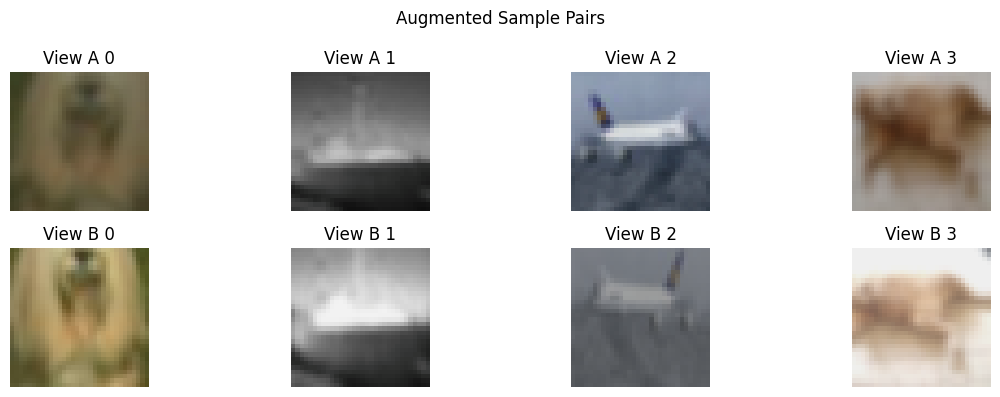

In [27]:
# visualize several augmented pairs
rng = np.random.RandomState(0)
idx = rng.choice(train_images.shape[0], size=min(4, train_images.shape[0]), replace=False)
fig, axes = plt.subplots(2, len(idx), figsize=(12, 4))
for i, id_ in enumerate(idx):
    v1, v2 = make_views(train_images[id_])
    img1 = (v1.transpose(1, 2, 0) * cifar_std + cifar_mean).clip(0, 1)
    img2 = (v2.transpose(1, 2, 0) * cifar_std + cifar_mean).clip(0, 1)
    axes[0, i].imshow(img1)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'View A {i}')
    axes[1, i].imshow(img2)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'View B {i}')
plt.suptitle('Augmented Sample Pairs')
plt.tight_layout()
plt.show()


## 数据集封装
`GeneratorDataset` 产出 `(view1, view2, label)`，标签仅用于可视化配色。


In [28]:
class SimCLRDataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        v1, v2 = make_views(img)
        return v1, v2, self.labels[idx]

train_gen = SimCLRDataset(train_images, train_labels)
train_ds = ds.GeneratorDataset(train_gen, ["view1", "view2", "label"], shuffle=True)
train_ds = train_ds.batch(batch_size, drop_remainder=True)




## 模型：轻量 CNN 编码器 + MLP 投影头
简化的卷积特征提取器，后接两层 MLP 投影。


In [29]:
class SimpleEncoder(nn.Cell):
    def __init__(self, out_dim=256):
        super().__init__()
        self.features = nn.SequentialCell([
            nn.Conv2d(3, 64, kernel_size=3, padding=1, pad_mode="pad"),
            nn.GroupNorm(8, 64), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, pad_mode="pad"),
            nn.GroupNorm(8, 128), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, pad_mode="pad"),
            nn.GroupNorm(16, 256), nn.ReLU(),
            nn.Conv2d(256, out_dim, kernel_size=3, padding=1, pad_mode="pad"),
            nn.GroupNorm(16, out_dim), nn.ReLU(),
        ])
        self.out_dim = out_dim
        self.pool = ops.ReduceMean(keep_dims=False)
    def construct(self, x):
        x = self.features(x)
        x = self.pool(x, (2, 3))
        return x

class ProjectionHead(nn.Cell):
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.SequentialCell([
            nn.Dense(in_dim, in_dim),
            nn.LayerNorm((in_dim,)),
            nn.ReLU(),
            nn.Dense(in_dim, proj_dim)
        ])
    def construct(self, x):
        return self.net(x)

class SimCLRNet(nn.Cell):
    def __init__(self, feature_dim=128):
        super().__init__()
        self.encoder = SimpleEncoder(out_dim=256)
        self.projection = ProjectionHead(self.encoder.out_dim, proj_dim=feature_dim)
    def construct(self, x1, x2):
        h1 = self.encoder(x1)
        h2 = self.encoder(x2)
        z1 = self.projection(h1)
        z2 = self.projection(h2)
        return z1, z2, h1, h2
    def encode(self, x):
        return self.encoder(x)


In [30]:
def l2_normalize(x, axis=1, eps=1e-8):
    # MindSpore ReduceSum 使用 keep_dims 参数
    axes = (axis,) if isinstance(axis, int) else axis
    reduce_sum = ops.ReduceSum(keep_dims=True)
    norm = ops.sqrt(reduce_sum(ops.square(x), axes) + eps)
    return x / norm


## 对比损失 NT-Xent
L2 归一化后计算相似度矩阵，正样本为同图两视角，其余为负样本。


In [31]:
def nt_xent_loss(z1, z2, temperature=0.5):
    batch_size = z1.shape[0]
    z = ops.concat((z1, z2), axis=0)
    z = l2_normalize(z, axis=1)
    similarity = ops.matmul(z, z.T)

    logits = similarity / temperature
    diag = ops.eye(2 * batch_size, dtype=ms.float32)
    logits = logits - 1e9 * diag

    exp_logits = ops.exp(logits)
    mask = 1 - diag
    reduce_sum = ops.ReduceSum(keep_dims=False)
    denom = reduce_sum(exp_logits * mask, 1)

    pos_sim = reduce_sum(z[:batch_size] * z[batch_size:], 1)
    pos = ops.concat((pos_sim, pos_sim), axis=0)
    pos_exp = ops.exp(pos / temperature)
    loss = -ops.log(pos_exp / denom)
    return ops.mean(loss)

class SimCLRWithLoss(nn.Cell):
    def __init__(self, net, temperature=0.5):
        super().__init__()
        self.net = net
        self.temperature = temperature
    def construct(self, view1, view2):
        z1, z2, _, _ = self.net(view1, view2)
        return nt_xent_loss(z1, z2, self.temperature)


## 训练器与循环
使用 `TrainOneStepCell` 封装前反向，示范只跑一轮，loss 记录在 `loss_history`。


In [32]:
model = SimCLRNet(feature_dim=feature_dim)
loss_cell = SimCLRWithLoss(model, temperature=temperature)
optimizer = nn.Adam(model.trainable_params(), learning_rate=learning_rate)
train_step = nn.TrainOneStepCell(loss_cell, optimizer)
train_step.set_train()

loss_history = []
for epoch in range(num_epochs):
    for step, batch in enumerate(train_ds.create_dict_iterator()):
        loss = train_step(batch["view1"], batch["view2"])
        loss_history.append(float(loss.asnumpy()))
        if step % 10 == 0:
            print(f"Epoch {epoch+1} Step {step}: loss={loss_history[-1]:.4f}")


Epoch 1 Step 0: loss=4.0767
Epoch 2 Step 0: loss=4.1197
Epoch 3 Step 0: loss=4.0010
Epoch 4 Step 0: loss=4.1505
Epoch 5 Step 0: loss=4.1292
Epoch 6 Step 0: loss=4.1364
Epoch 7 Step 0: loss=4.1304
Epoch 8 Step 0: loss=4.1240
Epoch 9 Step 0: loss=4.0818
Epoch 10 Step 0: loss=3.9717
Epoch 11 Step 0: loss=3.9338
Epoch 12 Step 0: loss=3.9295
Epoch 13 Step 0: loss=3.8563
Epoch 14 Step 0: loss=3.7194
Epoch 15 Step 0: loss=3.7955
Epoch 16 Step 0: loss=3.7950
Epoch 17 Step 0: loss=3.7514
Epoch 18 Step 0: loss=3.7923
Epoch 19 Step 0: loss=4.0721
Epoch 20 Step 0: loss=3.5752
Epoch 21 Step 0: loss=3.7663
Epoch 22 Step 0: loss=3.7599
Epoch 23 Step 0: loss=3.3067
Epoch 24 Step 0: loss=3.6808
Epoch 25 Step 0: loss=3.5477
Epoch 26 Step 0: loss=3.7292
Epoch 27 Step 0: loss=3.7102
Epoch 28 Step 0: loss=3.7616
Epoch 29 Step 0: loss=3.3899
Epoch 30 Step 0: loss=3.6224
Epoch 31 Step 0: loss=3.6648
Epoch 32 Step 0: loss=3.8179
Epoch 33 Step 0: loss=3.5308
Epoch 34 Step 0: loss=3.6664
Epoch 35 Step 0: loss=3

## Loss 曲线


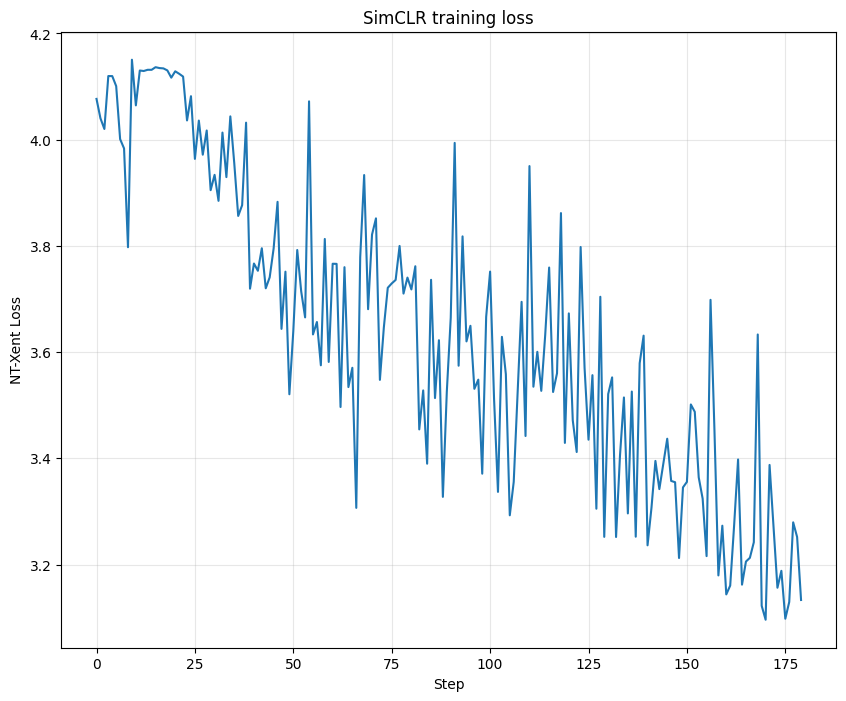

In [33]:
if loss_history:
    plt.figure(figsize=(10, 8))
    plt.plot(loss_history)
    plt.xlabel('Step')
    plt.ylabel('NT-Xent Loss')
    plt.title('SimCLR training loss')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("尚未运行训练循环。")


## t-SNE 可视化（选做）
抽样 1000 变成本子里只有 20 张测试，因此这里直接用抽样后的 20 张做 t-SNE。


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


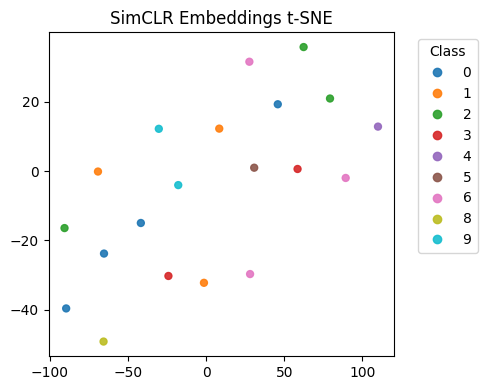

In [34]:
try:
    from sklearn.manifold import TSNE
    model.set_train(False)
    sample = test_images
    sample_labels = test_labels

    def eval_gen():
        for img, lab in zip(sample, sample_labels):
            arr = normalize(img).transpose(2, 0, 1)
            yield arr, lab
    eval_ds = ds.GeneratorDataset(eval_gen, ["image", "label"], shuffle=False)
    eval_ds = eval_ds.batch(len(sample))

    feats, labels_list = [], []
    for batch in eval_ds.create_dict_iterator():
        feat = model.encode(batch["image"])
        feats.append(feat.asnumpy())
        labels_list.append(batch["label"].asnumpy())
    feats = np.concatenate(feats)
    labels_np = np.concatenate(labels_list)

    tsne = TSNE(n_components=2, init='pca', random_state=42, learning_rate='auto', perplexity=max(5, len(labels_np)//2))
    reduced = tsne.fit_transform(feats)

    plt.figure(figsize=(5, 4))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels_np, cmap='tab10', s=25, alpha=0.9)
    plt.legend(*scatter.legend_elements(), title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('SimCLR Embeddings t-SNE')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("未安装 scikit-learn，跳过 t-SNE。")



## 余弦相似度分布（可选）
用抽样后的测试图做正负样本余弦相似度示意。


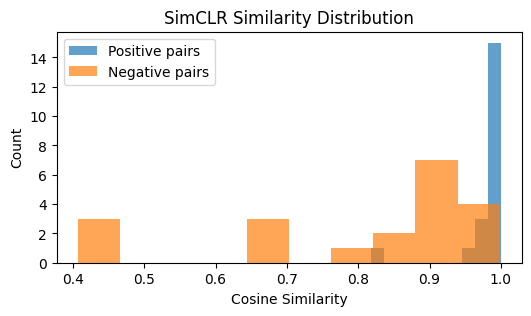

In [35]:
if loss_history:
    sample = test_images
    view_a, view_b = [], []
    for img in sample:
        v1, v2 = make_views(img)
        view_a.append(v1)
        view_b.append(v2)
    view_a = Tensor(np.stack(view_a), ms.float32)
    view_b = Tensor(np.stack(view_b), ms.float32)

    model.set_train(False)
    h1 = model.encode(view_a)
    h2 = model.encode(view_b)
    z1 = l2_normalize(h1)
    z2 = l2_normalize(h2)

    reduce_sum = ops.ReduceSum(keep_dims=False)
    pos_sim = reduce_sum(z1 * z2, 1).asnumpy()
    shuffled = np.random.permutation(z2.asnumpy())
    neg_sim = np.sum(z1.asnumpy() * shuffled, axis=1)

    plt.figure(figsize=(6,3))
    plt.hist(pos_sim, bins=10, alpha=0.7, label='Positive pairs', color='tab:blue')
    plt.hist(neg_sim, bins=10, alpha=0.7, label='Negative pairs', color='tab:orange')
    plt.legend()
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Count')
    plt.title('SimCLR Similarity Distribution')
    plt.show()
else:
    print('先完成训练再看分布。')

